# SVM for Classification

Reference  
https://zephyrus1111.tistory.com/211#c21

- 라이브러리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers

- 함수 선언

In [2]:
class BinarySVC():
    def __init__(self, kernel=None, coef0=0):
        self.labels_map = None
        self.kernel = kernel
        self.X = None
        self.y = None
        self.alphas = None
        self.w = None
        self.b = None
        self.coef0 = coef0
        
# 커널 함수 지정 -> 지정하지 않으면 soft-margin linear SVM 됨

        if kernel is not None:
            assert kernel in ['poly', 'rbf', 'sigmoid']

# 초평면 구하는 함수

    def fit(self, X, y, C):
        assert C >= 0, 'constant C must be non-negative'
        uniq_labels = np.unique(y)
        assert len(uniq_labels) == 2, 'the number of labels is 2'
        self.make_label_map(uniq_labels)
        self.X = X
        y = [self.transform_label(label, self.labels_map) for label in y] ## 1, -1로 변환
        y = np.array(y)
        ## formulating standard form
        m, n = X.shape
        y = y.reshape(-1,1)*1.
        self.y = y
        if self.kernel is not None:
            Q = np.zeros((m,m))
            for i in range(m):
                for j in range(m):
                    Q[i][j] = y[i]*y[j]*self.get_kernel_val(X[i], X[j])                       
        else:
            yX = y*X
            Q = np.dot(yX,yX.T)
        P = cvxopt_matrix(Q)
        q = cvxopt_matrix(-np.ones((m, 1)))
        G = cvxopt_matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt_matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
        A = cvxopt_matrix(y.reshape(1, -1))
        b = cvxopt_matrix(np.zeros(1))
        ## cvxopt configuration
        cvxopt_solvers.options['show_progress'] = False ## 결과 출력 X
        sol = cvxopt_solvers.qp(P, q, G, h, A, b) 
        alphas = np.array(sol['x'])
        S = (alphas>1e-4).flatten()
        if self.kernel is not None:
            sum_val = 0
            S_index = np.where(S==True)[0]
            for s in S_index:
                temp_vec = np.array([self.get_kernel_val(z, X[s]) for z in X])
                temp_vec = np.expand_dims(temp_vec, axis=1)
                sum_val += np.sum(y[s] - np.sum(y*alphas*temp_vec))
            b = sum_val/len(S)
            self.b = b
            
# w는 커널 사용하지 않을 때만 구함

        else:
            w = ((y*alphas).T@X).reshape(-1,1)
            b = np.mean(y[S] - np.dot(X[S],w))
            self.w = w
            self.b = b
        self.alphas = alphas
        return
    
    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return predictions
    
    def _predict(self, x):
        if self.kernel:
            temp_vec = np.array([self.get_kernel_val(x, y) for y in self.X])
            temp_vec = np.expand_dims(temp_vec, axis=1)
            S = (self.alphas>1e-4).flatten()
            res = np.sign(np.sum(self.y[S]*self.alphas[S]*temp_vec[S])+self.b)
        else:
            res = np.sign(self.w.T.dot(x)+self.b)
        res = self.inverse_label(res, self.labels_map)
        return res
    
# 원래 데이터 label을 -1, 1로 변환

    def make_label_map(self, uniq_labels):
        labels_map = list(zip([-1, 1], uniq_labels))
        self.labels_map = labels_map
        return
    
    def transform_label(self, label, labels_map):
        res = [l[0] for l in labels_map if l[1] == label][0]
        return res

    def inverse_label(self, svm_label, labels_map):
        try:
            res = [l[1] for l in labels_map if l[0] == svm_label][0]
        except:
            print(svm_label)
            print(labels_map)
            raise
        return res
    
# 커널 값 계산

    def get_kernel_val(self, x, y):
        X = self.X
        coef0 = self.coef0
        gamma = 1/(X.shape[1]*X.var())
        if self.kernel == 'poly':
            return (gamma*np.dot(x,y)+coef0)**2
        elif self.kernel == 'rbf':
            return np.exp(-gamma*np.square(np.linalg.norm(x-y)))
        else:
            return np.tanh(gamma*np.dot(x,y)+coef0)

In [3]:
class mySVM():
    def __init__(self, svm_type='classification', kernel=None, coef0=0):
        
# 분류 또는 회귀 선택

        assert svm_type in ['classification', 'regression']
        self.svm_type = svm_type
        self.kernel=kernel
        self.X = None
        self.y = None
        self.coef0 = coef0
        self.model_list = None
        if kernel is not None:
            assert kernel in ['poly', 'rbf', 'sigmoid']
            
    def fit(self, X, y, C, epsilon=0.1):
        if self.svm_type == 'classification':
            self._fit_svc(X, y, C)
        else:
            self._fit_svr(X, y, C, epsilon)
            
# classification (SVM)
            
    def _fit_svc(self, X, y, C):
        uniq_labels = np.unique(y)
        label_combinations = list(combinations(uniq_labels, 2))
        model_list = []
        for lc in label_combinations:
            target_idx = np.array([x in lc for x in y])
            y_restricted = y[target_idx]
            X_restricted = X[target_idx]
            
# BinarySVC 사용
            
            clf = BinarySVC(kernel=self.kernel, coef0=self.coef0)
            clf.fit(X_restricted, y_restricted, C)
            model_list.append(clf)
        self.model_list = model_list
        return
    
# regression (SVR)
    
    def _fit_svr(self, X, y, C, epsilon):
        assert C >= 0, 'constant C must be non-negative'
        assert epsilon > 0, 'epsilon C must be positive'
        self.X = X
        m, n = X.shape
        y = y.reshape(-1,1)*1.
        self.y = y
        if self.kernel is not None:
            Q = np.zeros((m,m))
            for i in range(m):
                for j in range(m):
                    Q[i][j] = self.get_kernel_val(X[i], X[j])
        else:
            Q = X.dot(X.T)
        I = np.eye(m)
        O = np.zeros((m, m))
        sub_Q = np.hstack([I, -I])
        main_Q = sub_Q.T.dot(Q.dot(sub_Q))
        P = cvxopt_matrix(main_Q)
        q = cvxopt_matrix(epsilon*np.ones((2*m, 1)) - np.vstack([y, -y]))

        G = np.vstack([np.hstack([-I, O]), np.hstack([I, O]), np.hstack([O, -I]), np.hstack([O, I])])
        G = cvxopt_matrix(G)
        h = cvxopt_matrix(np.hstack([np.zeros(m), C*np.ones(m)]*2))
        A = cvxopt_matrix(np.ones((m,1)).T.dot(sub_Q))
        b = cvxopt_matrix(np.zeros(1))
        
        cvxopt_solvers.options['show_progress'] = False
        sol = cvxopt_solvers.qp(P, q, G, h, A, b)
        sol_root = np.array(sol['x'])
        alphas = sol_root[:m]
        alphas_star = sol_root[m:]
        
        S = (alphas>1e-4).flatten()       
        if self.kernel is not None:
            sum_val = []
            S_index = np.where(S==True)[0]
            for s in S_index:
                temp_vec = np.array([self.get_kernel_val(z, X[s]) for z in X])
                temp_vec = np.expand_dims(temp_vec, axis=1)
                sum_val.append(-epsilon + np.sum(y[s] - np.sum((alphas-alphas_star)*temp_vec)))
            b = min(sum_val)
            self.b = b
        else:
            w = alphas.T.dot(X)-alphas_star.T.dot(X)
            w = w.reshape(-1,1)
            b = -epsilon+np.min(y[S] - np.dot(X[S],w))
            self.w = w
            self.b = b
        self.alphas = sol_root
        return
    
    def predict(self, X):
        if self.svm_type =='classification':
            model_list = self.model_list
            prediction = [model.predict(X) for model in model_list]
            prediction = [Counter(pred).most_common(1)[0][0] for pred in list(zip(*prediction))]
        else:
            prediction = [self._predict_reg(x) for x in X]
        return prediction
    
    def _predict_reg(self, x):
        if self.kernel is not None:
            m, _ = self.X.shape
            sol_root = self.alphas
            alphas = sol_root[:m]
            alphas_star = sol_root[m:]
            
            temp_vec = np.array([self.get_kernel_val(z, x) for z in X])
            temp_vec = np.expand_dims(temp_vec, axis=1)
            pred = np.sum((alphas-alphas_star)*temp_vec)+self.b
        else:
            w = self.w
            b = self.b
            pred = w.dot(x)+b
            pred = pred[0]
        return pred
    
# 커널 값 계산
    
    def get_kernel_val(self, x, y):
        X = self.X
        coef0 = self.coef0
        gamma = 1/(X.shape[1]*X.var())
        if self.kernel == 'poly':
            return (gamma*np.dot(x,y)+coef0)**2
        elif self.kernel == 'rbf':
            return np.exp(-gamma*np.square(np.linalg.norm(x-y)))
        else:
            return np.tanh(gamma*np.dot(x,y)+coef0)

### Soft Margin + Kernel Trick에서 kernel 별(Polynomial, Gaussian, Sigmoid) C 값 변화에 따른(1~100) 정확도 변화 관찰

### Dataset 1 : Iris data  
꽃받침과 꽃잎의 너비, 길이를 통해 붓꽃을 세 종류로 분류하는 데이터

In [4]:
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = [iris.target_names[x] for x in iris.target]
 
species_to_labels = dict(zip(df['species'].unique(), range(len(df['species'].unique()))))
df['species'] = df['species'].map(species_to_labels)
df = df.rename(columns={'species':'label'})
 
X = df.drop('label', axis=1).values
y = df['label'].values

(1) Polynomial kernel

In [6]:
clf = mySVM(svm_type='classification', kernel='poly')
poly = []
for i in range(1,101) :
    clf.fit(X, y, C=i)
    pred = clf.predict(X)
    poly.append(np.mean(y == pred))

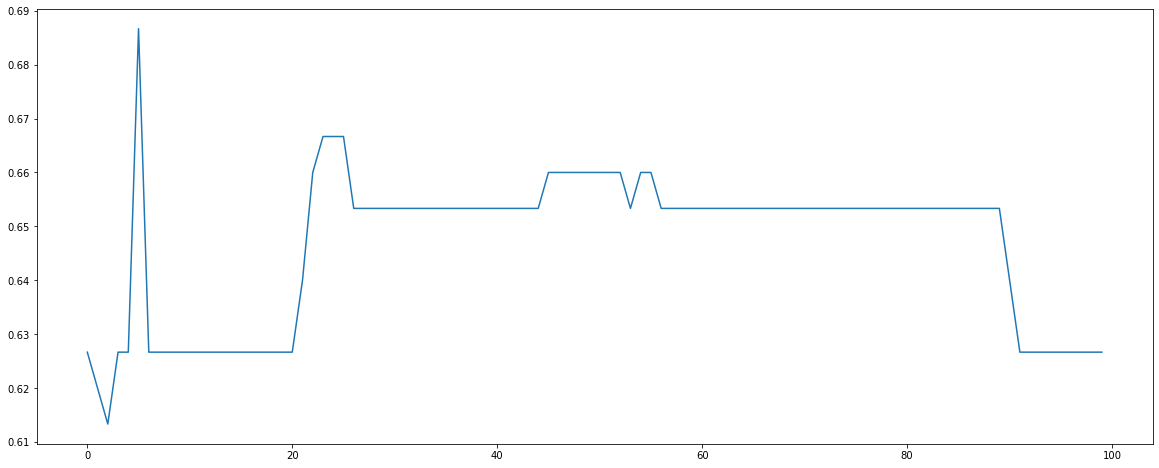

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(poly)

In [31]:
np.argmax(poly)

5

Polynomial kernel을 사용하는 경우 C가 6일 때 가장 좋은 성능을 보인다.

(2) Gaussian(RBF) kernel

In [11]:
clf = mySVM(svm_type='classification', kernel='rbf')
rbf = []
for i in range(1,101) :
    clf.fit(X, y, C=i)
    pred = clf.predict(X)
    rbf.append(np.mean(y == pred))

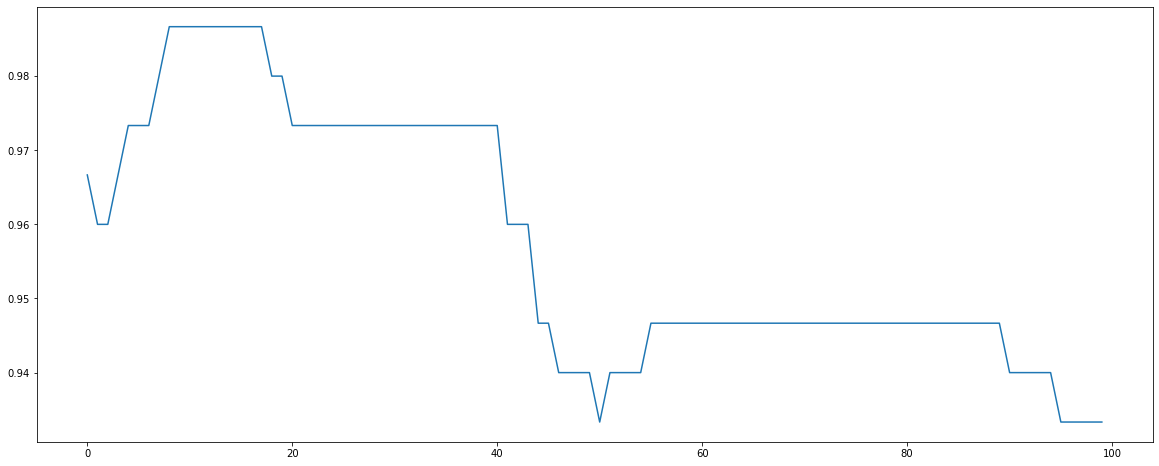

In [25]:
plt.figure(figsize=(20,8))
plt.plot(rbf)

In [32]:
np.argmax(rbf)

8

Gaussian(RBF) kernel은 C가 9 정도에서 가장 좋은 성능을 보인다.  
C가 20을 넘으면 성능이 점차 떨어진다.

(3) Sigmoid kernel

In [13]:
clf = mySVM(svm_type='classification', kernel='sigmoid')
sigmoid = []
for i in range(1,101) :
    clf.fit(X, y, C=i)
    pred = clf.predict(X)
    sigmoid.append(np.mean(y == pred))

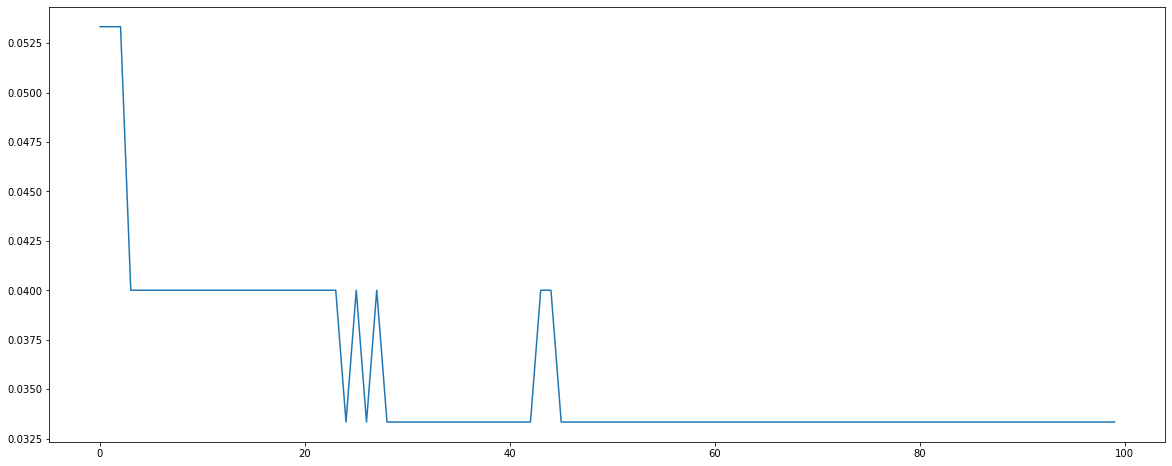

In [26]:
plt.figure(figsize=(20,8))
plt.plot(sigmoid)

In [34]:
np.argmax(sigmoid)

0

Sigmoid kernel은 C가 1일 때 가장 좋은 성능을 보인다.  
이후로는 점점 성능이 떨어진다.

(4) 전체 비교

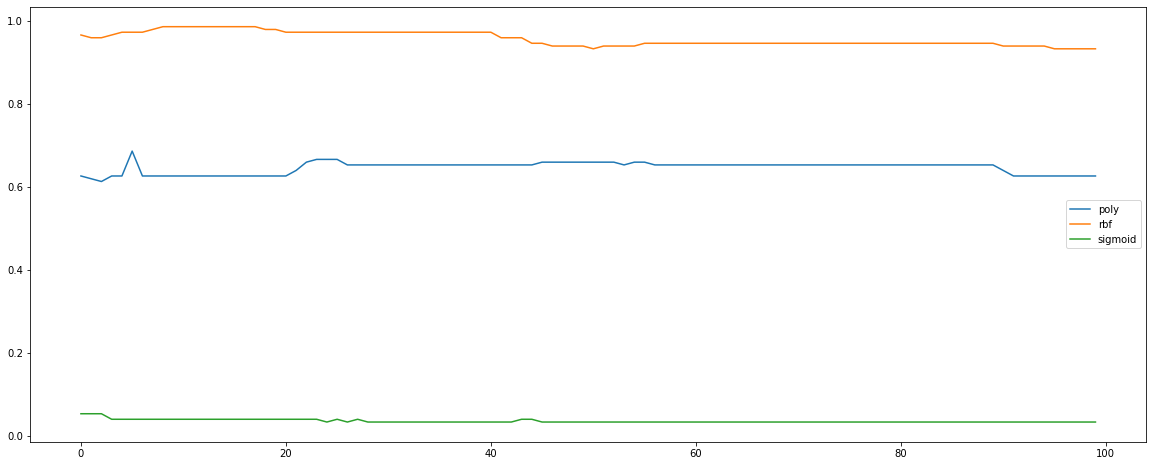

In [47]:
plt.figure(figsize=(20,8))
plt.plot(poly, label='poly')
plt.plot(rbf, label='rbf')
plt.plot(sigmoid, label='sigmoid')
plt.legend()

세 kernel의 성능을 비교해보자면, Gaussian(RBF) kernel > Polynomial kernel > Sigmoid kernel 순으로 성능이 좋다.  
C의 변화에 따라 세 kernel의 성능 순위가 달라지지는 않는다.

### Dataset 2 : Breast cancer data  
세포에 대한 정보를 통해 유방암 발병 유무를 분류하는 데이터

In [4]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['class'] = [cancer.target_names[x] for x in cancer.target]
 
classes_to_labels = dict(zip(df['class'].unique(), range(len(df['class'].unique()))))
df['class'] = df['class'].map(classes_to_labels)
df = df.rename(columns={'class':'label'})
 
X = df.drop('label', axis=1).values
y = df['label'].values

In [5]:
import gc
import matplotlib.pyplot as plt


gc.collect()

0

(1) Polynomial kernel

0


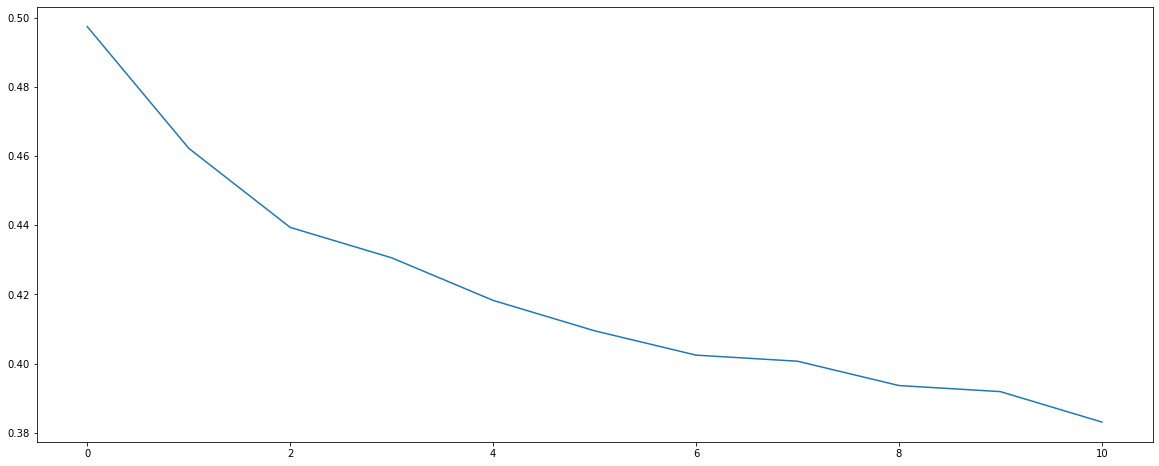

In [6]:
clf = mySVM(svm_type='classification', kernel='poly')
c_list = [1,10,20,30,40,50,60,70,80,90,100]
poly = []
for i in c_list :
    clf.fit(X, y, C=i)
    pred = clf.predict(X)
    poly.append(np.mean(y == pred))

plt.figure(figsize=(20,8))
plt.plot(poly)

print(np.argmax(poly))

Polynomial kernel을 사용하는 경우 C가 1일 때 가장 좋은 성능을 보이고, 이후로는 점점 성능이 떨어진다.

(2) Gaussian(RBF) kernel

2


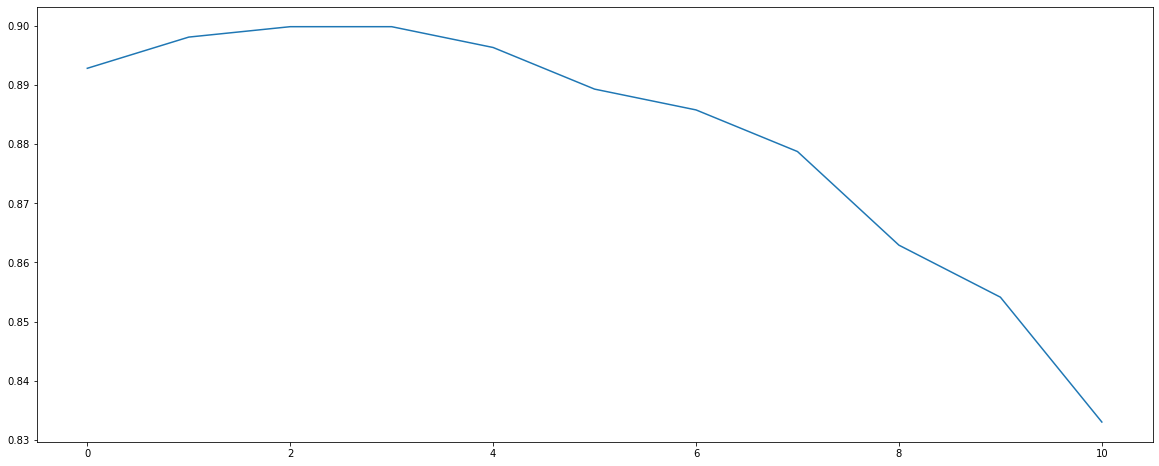

In [7]:
clf = mySVM(svm_type='classification', kernel='rbf')
c_list = [1,10,20,30,40,50,60,70,80,90,100]
rbf = []
for i in c_list :
    clf.fit(X, y, C=i)
    pred = clf.predict(X)
    rbf.append(np.mean(y == pred))

plt.figure(figsize=(20,8))
plt.plot(rbf)

print(np.argmax(rbf))

Gaussian(RBF) kernel은 C가 3일 때 가장 좋은 성능을 보이고, 이후 점차 성능이 떨어진다.

(3) Sigmoid kernel

In [6]:
clf = mySVM(svm_type='classification', kernel='sigmoid')
c_list = [1,10,20,30,40,50,60,70,80,90,100]
sigmoid = []
for i in c_list :
    clf.fit(X, y, C=i)
    pred = clf.predict(X)
    sigmoid.append(np.mean(y == pred))

plt.figure(figsize=(20,8))
plt.plot(sigmoid)

print(np.argmax(sigmoid))

ValueError: Rank(A) < p or Rank([P; A; G]) < n

잘 작동하다가 갑자기 안되는데 문제를 해결하지 못 함

(4) 전체 비교

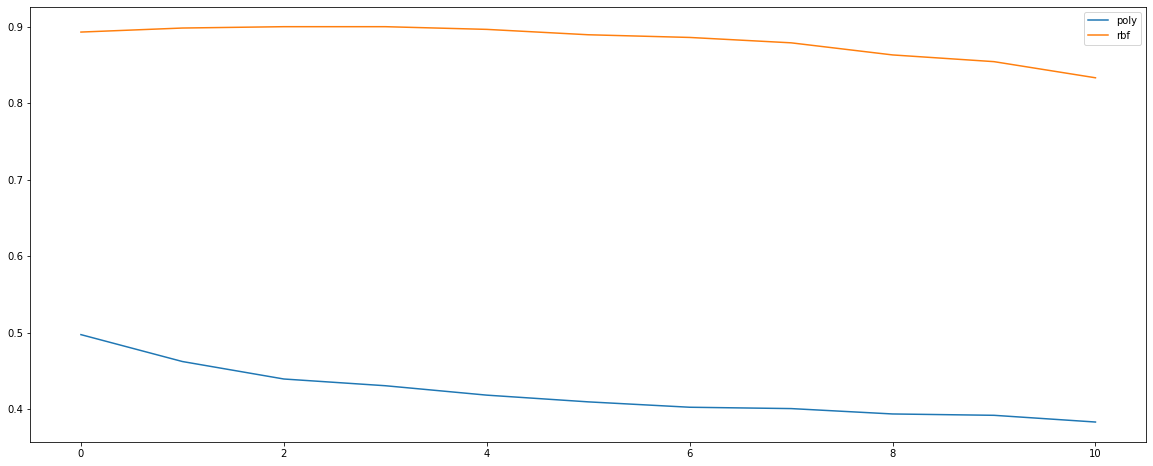

In [9]:
plt.figure(figsize=(20,8))
plt.plot(poly, label='poly')
plt.plot(rbf, label='rbf')
# plt.plot(sigmoid, label='sigmoid')
plt.legend()

두 kernel의 성능을 비교해보자면, Gaussian(RBF) kernel > Polynomial kernel 순으로 성능이 좋다.
C의 변화에 따라 두 kernel의 성능 순위가 달라지지는 않는다.

### 종합

세 kernel의 성능을 종합적으로 정리해보면, Gaussian(RBF) kernel > Polynomial kernel > Sigmoid kernel 순으로 성능이 좋다고 볼 수 있다.  
C의 변화에 따라 각 kernel 내부적으로 성능이 약간씩 차이가 있지만, 전체적으로 세 kernel의 성능 순위가 달라지지는 않는다.  
Gaussian(RBF) kernel의 성능이 가장 좋기 때문에 다른 테스크에서도 우선적으로 적용해보면 좋을 것 같다.